In [47]:
import numpy as np
import math as m
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

\begin{align*}
\begin{bmatrix}
\dot{x} \\ \dot{y} \\ \dot{\theta}
\end{bmatrix}&= \begin{bmatrix}
\frac{r}{2}(u_r + u_l)\cos\theta \\
\frac{r}{2}(u_r + u_l)\sin\theta \\
\frac{r}{L}(u_r - u_l)
\end{bmatrix}
\end{align*}

In [2]:
r = 0.025 #radius of wheels
L = 0.09 # length of axle
W = 0.1 # width of robot
l = L/3.
#r = 0.5
#L = 1.
#W = 1.
radian_vel_limit = 2*np.pi

radian_input_limit = 2*np.pi

op_space_xmin = 0.
op_space_xmax = 2.
op_space_ymin = 0.
op_space_ymax = 2.

V_max = 2*np.pi*r # maximum forward velocity in any direction

#process noise variances
input_variance = (0.05*radian_vel_limit)**2

#measurement variances
distance_measurement_variance = (0.9*0.03)**2
theta_measurement_variance = (2*np.pi/9600)**2
theta_dot_measurement_variance = ((0.1)*np.pi/180)**2

# function describing system dynamics
# xdot = f(x,u)
def dynamics(x,t,u):
    global r
    global L
    xdot = r*np.cos(x[2])*(u[0]+x[3]+u[1]+x[4])/2.0
    ydot = r*np.sin(x[2])*(u[0]+x[3]+u[1]+x[4])/2.0
    theta_dot = (r/L)*((u[1]+x[3])-(u[0]+x[4]))
    nu_dot = np.random.normal(0,np.sqrt(input_variance),2)
    return np.array([xdot,ydot,theta_dot,nu_dot[0],nu_dot[1]])
    #return np.array([xdot,ydot,theta_dot,0,0])

def wrap_angle(theta):
    return (theta + np.pi) % (2 * np.pi) - np.pi

def get_output(x,u):
    y = np.empty(4)
    y[0] = x[2] + np.random.normal(loc=0,scale=np.sqrt(theta_measurement_variance))
    y[1] = r/L*(u[1]-u[0]) + np.random.normal(loc=0,scale=np.sqrt(theta_dot_measurement_variance))
    eps = np.finfo(float).eps
    theta = wrap_angle(x[2])
    #parallel and perpendicular vectors
    par = np.array([np.cos(x[2]), np.sin(x[2])])
    perp_angle = wrap_angle(x[2]-np.pi/2.)
    perp = np.array([np.cos(perp_angle),np.sin(perp_angle)])
    
    #compute forward distance to a wall
    if abs(par[0]) <= eps :
        c = max((op_space_ymax-x[1]), (op_space_ymin-x[1]))
    elif abs(par[1]) <= eps :
        c = max((op_space_xmax-x[0]), (op_space_xmin-x[0]))
    else:    
        if (0 < theta <= np.pi/2.) :
            c = min((op_space_xmax-x[0])/par[0], (op_space_ymax-x[1])/par[1])
        elif (np.pi/2 < x[2] <= np.pi) :
            c = min((op_space_xmin-x[0])/par[0], (op_space_ymax-x[1])/par[1])
        elif (-np.pi < theta <= -np.pi/2.) :
            c = min((op_space_xmin-x[0])/par[0], (op_space_ymin-x[1])/par[1])
        elif (-np.pi/2 < theta <= 0) :
            c = min((op_space_xmax-x[0])/par[0], (op_space_ymin-x[1])/par[1])
    y[2] = c + np.random.normal(loc=0,scale=np.sqrt(distance_measurement_variance))
    
    #compute rightward distance to a wall
    if abs(perp[0]) <= eps :
        c = max((op_space_ymax-x[1]), (op_space_ymin-x[1]))
    elif abs(perp[1]) <=eps :
        c = max((op_space_xmax-x[0]), (op_space_xmin-x[0]))
    else :
        if (0 < theta <= np.pi/2.) :
            c = min((op_space_xmax-x[0])/perp[0], (op_space_ymin-x[1])/perp[1])
        elif (np.pi/2 < theta <= np.pi) :
            c = min((op_space_xmax-x[0])/perp[0], (op_space_ymax-x[1])/perp[1])
        elif (-np.pi < theta <= -np.pi/2.) :
            c = min((op_space_xmin-x[0])/perp[0], (op_space_ymax-x[1])/perp[1])
        elif (-np.pi/2 < theta <= 0) :
            c = min((op_space_xmin-x[0])/perp[0], (op_space_ymin-x[1])/perp[1])
    y[3] = c + np.random.normal(loc=0,scale=np.sqrt(distance_measurement_variance))
    return y

def delta_angle(x_1,x_2):
    vect = (x_2[0:2]-x_1[0:2])/(np.linalg.norm(x_2[0:2]-x_1[0:2])) # normalized vector pointing between points
    current_orient = np.array([np.cos(x_1[2]), np.sin(x_1[2])])
    sin_value = np.clip(np.cross(current_orient,vect),-1.,1.)
    cos_value = np.clip(np.dot(vect,current_orient),-1.,1.)
    return m.copysign(np.arccos(cos_value),sin_value)

def compute_input(state_1,state_2):
    angle_diff = delta_angle(state_1,state_2)
    u_r = (V_max/r)*(np.cos(angle_diff) - (L/(2*l))*np.sin(angle_diff))
    u_l = (V_max/r)*(np.cos(angle_diff) + (L/(2*l))*np.sin(angle_diff))
    u = np.array([u_r,u_l])
    if any(abs(u) > radian_input_limit):
        u *= radian_input_limit/max(abs(u))
    return u

def t_sec_trajectory_constant_input(x_0,x_d,u_input,t):
    steps = m.ceil(t*100) #100 steps per second
    sub_steps = 50
    x = np.zeros([5,steps+1])
    y = np.zeros([4,steps+1])
    u = np.zeros([2,steps+1])
    t = np.linspace(0.,t/steps,sub_steps)
    x[:,0] = x_0
    for step in range(steps):
        u[:,step] = u_input
        y[:,step] = get_output(x[:,step],u[:,step])
        sol = odeint(dynamics,x[:,step],t,args=(u[:,step],))
        x[:,step+1] = sol[-1,:]
    u[:,step+1] = compute_input(x[:,step+1],x_d)
    y[:,step+1] = get_output(x[:,step+1],u[:,step+1])
    return x,y

def t_sec_trajectory(x_0,x_d,t):
    steps = m.ceil(t*100) #100 steps per second
    sub_steps = 20
    x = np.zeros([5,steps+1])
    y = np.zeros([4,steps+1])
    u = np.zeros([2,steps+1])
    t = np.linspace(0.,t/steps,sub_steps)
    x[:,0] = x_0
    for step in range(steps):
        u[:,step] = compute_input(x[:,step],x_d)
        y[:,step] = get_output(x[:,step],u[:,step])
        sol = odeint(dynamics,x[:,step],t,args=(u[:,step],))
        x[:,step+1] = sol[-1,:]
    u[:,step+1] = compute_input(x[:,step+1],x_d)
    y[:,step+1] = get_output(x[:,step+1],u[:,step+1])
    return x,y,u

def t_sec_trajectory_quick(x_0,x_d,t):
    steps = m.ceil(t*30) #30 steps per second
    sub_steps = 10
    x = np.zeros(5)
    y = np.zeros(4)
    u = np.zeros(2)
    t = np.linspace(0.,t/steps,sub_steps)
    x = x_0
    for step in range(steps):
        u = compute_input(x,x_d)
        #y[:,0] = get_output(x[:,step],u[:,step])
        x = odeint(dynamics,x,t,args=(u,))[-1,:]
    u = compute_input(x,x_d)
    y = get_output(x,u)
    return x,y

def plot_trajectory(x,y):
    f = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    steps = np.shape(x)[1]
    ax.scatter(x[0,0],x[1,0],marker='s',color='green',s=1000) # plot green square at initial point
    ax.plot(x[0,0:steps],x[1,0:steps])
    for hop in range(0,steps,20):
        ax.quiver(x[0,hop],x[1,hop],np.cos(x[2,hop]),np.sin(x[2,hop]))
        
        par_point = np.array([np.cos(x[2,hop])*y[2,hop]+x[0,hop], np.sin(x[2,hop])*y[2,hop]+x[1,hop]])
        perp_point = np.array([np.cos(x[2,hop]-np.pi/2.)*y[3,hop]+x[0,hop], np.sin(x[2,hop]-np.pi/2.)*y[3,hop]+x[1,hop]])
        par_line = np.array([[x[0,hop],x[1,hop]],par_point])
        perp_line = np.array([[x[0,hop],x[1,hop]],perp_point])
        ax.plot(par_line[:,0],par_line[:,1],color='red',alpha=0.4)
        ax.plot(perp_line[:,0],perp_line[:,1],color='blue',alpha=0.4)

/Users/atonofbuns/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/atonofbuns/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


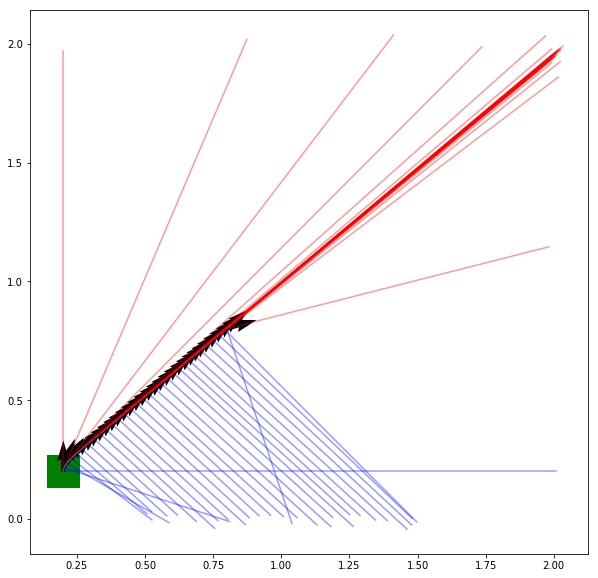

In [3]:
x_0 = np.array([0.2,0.2,np.pi/2.,0,0])
x_d = np.array([0.8,0.8,0,0,0])
t = 6.0

#print(delta_angle(x_0,x_d)/np.pi)

(x,y,u) = t_sec_trajectory(x_0,x_d,t)

plot_trajectory(x,y)

In [62]:
x_0 = np.array([1.5,0.1,0,0,0])
x_d = np.array([0.5,1.8,0,0,0])
#P_0 = np.zeros([5,5])
P_0 = np.diag(0.001*np.ones(5))

#process_noise_covariance = np.zeros([3,3])
process_noise_covariance = np.zeros([5,5])
process_noise_covariance[3,3] = input_variance
process_noise_covariance[4,4] = input_variance

#process_noise_covariance = np.array([[0.00001,0,0],
#                                     [0,0.00001,0],
#                                     [0,0,0.00001]])

output_noise_covariance = np.zeros([4,4])
output_noise_covariance[0,0] = theta_measurement_variance
output_noise_covariance[1,1] = theta_dot_measurement_variance
output_noise_covariance[2,2] = distance_measurement_variance
output_noise_covariance[3,3] = distance_measurement_variance

#output_noise_covariance = np.array([[0.00001,0,0,0],
#                                    [0,0.00001,0,0],
#                                    [0,0,0.00001,0],
#                                    [0,0,0,0.00001]])
state_min = np.array([op_space_xmin, op_space_ymin, -np.pi, -np.inf, -np.inf])
state_max = np.array([op_space_xmax, op_space_ymax, np.pi, np.inf, np.inf])

#Initialize parameters
steps = 100
delta_t = 0.1 #seconds/step
n = 5
sigma_points = np.empty([5,2*n+1,steps]) #sigma points to evolve
z = np.empty([4,2*n+1,steps]) #outputs
w = np.empty([2*n+1]) #weights of sigma points
state_cov = np.empty([5,5]) #covariances of state forecast
output_cov = np.empty([4,4])#covariance of output forecast
cross_cov = np.empty([5,4])
P = np.empty([5,5,steps])

real_x = np.empty([5,steps])
real_z = np.empty([4,steps])

P[:,:,0] = P_0
sigma_points[:,0,0] = x_0
real_x[:,0] = x_0
w[0] = -0.99
for i in range(2*n+1):
    w[i] = (1-w[0])/(2*n)
S = np.linalg.cholesky(np.sqrt(n/(1-w[0]))*P[:,:,0])

u = np.empty([2,2*n+1])

for t in range(1,steps):
    print('T-STEP',t)
    start = time.time()
    #########################################################
    #                  SELECT SIGMA POINTS                  #
    #########################################################
    S = np.linalg.cholesky((n/(1-w[0]))*P[:,:,t-1]) 
    for i in range(n):
        sigma_points[:,i+1,t-1] = np.clip(sigma_points[:,0,t-1] + S[:,i], state_min, state_max)
    for i in range(n):
        sigma_points[:,n+i+1,t-1] = np.clip(sigma_points[:,0,t-1] - S[:,i], state_min, state_max)
    #print('Selected points in %s seconds' %(time.time()-start))
    #########################################################
    #                  EVOLVE SIGMA POINTS                  #
    #########################################################
    #Evolve sigma points through process and extract output
    start = time.time()
    for i in range(2*n+1):
        sigma_points[:,i,t],z[:,i,t] = t_sec_trajectory_quick(sigma_points[:,i,t-1],x_d,delta_t) #evolve sigma point
    #print('evolved points in %s seconds' %(time.time()-start))
    #Compute new mean of sigma point states and outputs
    start = time.time()
    avg_state = np.average(sigma_points[:,:,t], axis=1, weights=w)
    avg_output = np.average(z[:,:,t], axis=1, weights=w)

    #Compute new covariances of evolved states, outputs, and their cross-covariances
    state_cov = np.zeros([5,5])
    output_cov = np.zeros([4,4])
    cross_cov = np.zeros([5,4])
    for i in range(2*n+1):
        state_cov += w[i]*np.outer(sigma_points[:,i,t]-avg_state, sigma_points[:,i,t]-avg_state)
        output_cov += w[i]*np.outer(z[:,i,t]-avg_output,z[:,i,t]-avg_output)
        cross_cov += w[i]*np.outer(sigma_points[:,i,t]-avg_state,z[:,i,t]-avg_output)
    state_cov += process_noise_covariance
    output_cov += output_noise_covariance
    #print('computed new covariances in %s seconds' %(time.time()-start))
    #true evolution of state
    real_u = compute_input(real_x[:,t-1],x_d)
    real_x[:,t],real_z[:,t] = t_sec_trajectory_quick(real_x[:,t-1],x_d,delta_t)
    print('REAL STATE at time %s : %s' %(t,real_x[:,t]))
    start = time.time()
    K = np.matmul(cross_cov,np.linalg.inv(output_cov))
    sigma_points[:,0,t] = avg_state + np.matmul(K,real_z[:,t]-avg_output)
    sigma_points[2,0,t] = wrap_angle(sigma_points[2,0,t])
    sigma_points[:,0,t] = np.clip(sigma_points[:,0,t],state_min,state_max)
    P[:,:,t] = state_cov - np.matmul(np.matmul(K,output_cov),np.transpose(K))
    #print('computed estimate in %s seconds' %(time.time()-start))
    print('ESTIMATED STATE at time %s : %s' %(t,sigma_points[:,0,t]))
    P[:,:,t] = 0.5*(P[:,:,t] + np.transpose(P[:,:,t]))

    

T-STEP 1
REAL STATE at time 1 : [ 1.49622759  0.09954804  0.26384223 -0.04448592  0.01248559]
ESTIMATED STATE at time 1 : [1.49707931 0.08857575 0.26308032 0.01705226 0.02662848]
T-STEP 2
REAL STATE at time 2 : [1.49623536 0.08850011 0.79333353 0.03535041 0.02362165]
ESTIMATED STATE at time 2 : [1.49075267 0.09148732 0.79241286 0.19119316 0.0257677 ]
T-STEP 3
REAL STATE at time 3 : [1.49811822 0.0911392  1.07298435 0.07064918 0.03132708]
ESTIMATED STATE at time 3 : [1.49707847 0.09059821 1.07363563 0.20415952 0.16119017]
T-STEP 4
REAL STATE at time 4 : [1.50001287 0.09601352 1.30949636 0.05674787 0.04801104]
ESTIMATED STATE at time 4 : [1.50056695 0.09276394 1.30973303 0.06951764 0.14826331]
T-STEP 5
REAL STATE at time 5 : [1.50107983 0.102819   1.50904216 0.07452436 0.04835421]
ESTIMATED STATE at time 5 : [1.50057546 0.10135351 1.50892997 0.08254478 0.25721405]
T-STEP 6
REAL STATE at time 6 : [1.50086158 0.1112882  1.67468839 0.08028263 0.053747  ]
ESTIMATED STATE at time 6 : [1.50118

REAL STATE at time 48 : [1.17048879 0.68208577 2.1127348  0.29552536 0.27794658]
ESTIMATED STATE at time 48 : [ 1.17156152  0.67948256  2.11264501 -0.04017752 -0.0736687 ]
T-STEP 49
REAL STATE at time 49 : [1.16204319 0.69611857 2.11243035 0.28460035 0.27590993]
ESTIMATED STATE at time 49 : [ 1.16415261  0.69181255  2.11225446 -0.0319651  -0.13436582]
T-STEP 50
REAL STATE at time 50 : [1.15359873 0.71016011 2.11211681 0.29038176 0.2714442 ]
ESTIMATED STATE at time 50 : [ 1.15737846  0.70310858  2.11143978 -0.03735387 -0.12273384]
T-STEP 51
REAL STATE at time 51 : [1.14515589 0.72420689 2.111816   0.2846432  0.28158801]
ESTIMATED STATE at time 51 : [ 1.14980434  0.71573225  2.1114601  -0.02266771 -0.03688325]
T-STEP 52
REAL STATE at time 52 : [1.13671542 0.73825946 2.11154877 0.27917415 0.27317771]
ESTIMATED STATE at time 52 : [1.14736019 0.71986461 2.11129204 0.09859278 0.07907423]
T-STEP 53
REAL STATE at time 53 : [1.12827923 0.75230887 2.11169555 0.29351988 0.26644802]
ESTIMATED STAT

REAL STATE at time 93 : [ 0.80483173  1.2701135   2.0995279  -0.50965845 -0.42137618]
ESTIMATED STATE at time 93 : [ 0.80863352  1.26363793  2.09971665 -0.48171605 -0.12965594]
T-STEP 94
REAL STATE at time 94 : [ 0.78719948  1.30165924  2.07605744 -0.56225198 -0.1559767 ]
ESTIMATED STATE at time 94 : [ 0.79734701  1.28354587  2.07564247 -0.8776993  -0.18881539]
T-STEP 95
REAL STATE at time 95 : [ 0.78024672  1.31425881  2.07420756 -0.55525814 -0.15263091]
ESTIMATED STATE at time 95 : [ 0.78792454  1.30055862  2.07358756 -0.59302222 -0.16829005]
T-STEP 96
REAL STATE at time 96 : [ 0.77332592  1.32683739  2.07349562 -0.55572823 -0.15494669]
ESTIMATED STATE at time 96 : [ 0.77667379  1.32109675  2.07384892 -0.5211115  -0.14391016]
T-STEP 97
REAL STATE at time 97 : [ 0.76641989  1.33940077  2.07348548 -0.54214945 -0.16067824]
ESTIMATED STATE at time 97 : [ 0.77013138  1.33307586  2.07383134 -0.5010793  -0.14200706]
T-STEP 98
REAL STATE at time 98 : [ 0.75950682  1.35196755  2.07401948 -0.5

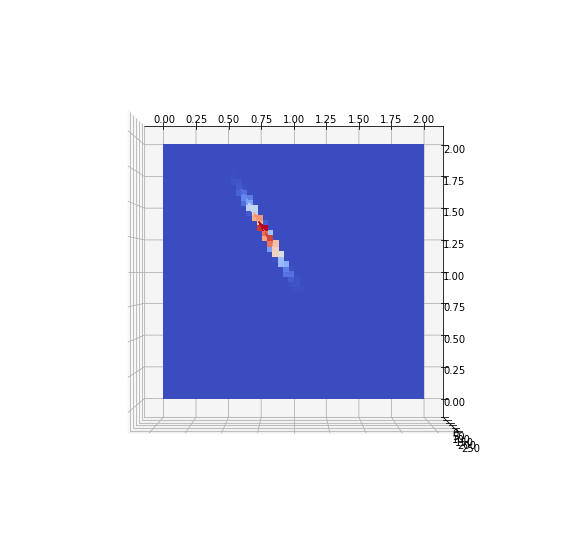

In [105]:
#pt = np.array([0.2,0.2])
xaxis = np.linspace(op_space_xmin,op_space_xmax,1000)
yaxis = np.linspace(op_space_ymin,op_space_ymax,1000)
X,Y = np.meshgrid(xaxis,yaxis)
Z = np.zeros(X.shape)

step = 95

mu = sigma_points[0:2,0,step]
sigma = 500*P[0:2,0:2,step]
for i in range(1000):
    for j in range(1000):
        Z[i,j] = multivariate_normal.pdf(x=np.array([X[i,j],Y[i,j]]),mean=mu,cov=sigma)

f = plt.figure(figsize=(10,10))
ax = f.gca(projection='3d')
ax.view_init(elev=90,azim=-90)
ax.plot_surface(X,Y,Z,cmap=cm.coolwarm,linewidth=0,antialiased=False)           
plt.show()

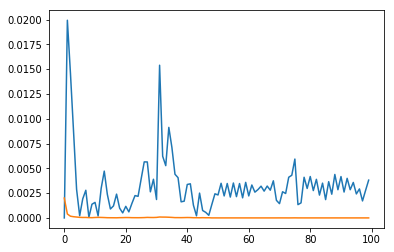

In [5]:
norm_diffs =np.zeros(steps)
for t in range(steps):
    norm_diffs[t] = np.linalg.norm(real_x[0,t]-sigma_points[0,0,t])
plt.plot(norm_diffs)
plt.plot(P[1,1,:]+P[2,2,:])
plt.show()

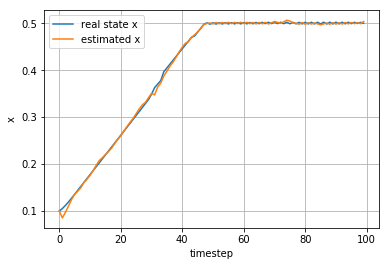

In [7]:
plt.plot(real_x[0,:],label='real state x')
plt.plot(sigma_points[0,0,:],label='estimated x')
plt.xlabel('timestep')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()

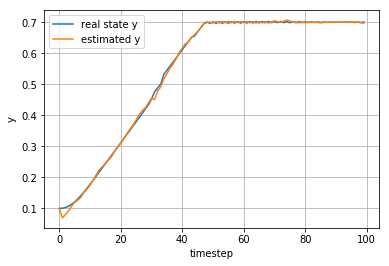

In [8]:
plt.plot(real_x[1,:],label='real state y')
plt.plot(sigma_points[1,0,:],label='estimated y')
plt.xlabel('timestep')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

Text(0, 0.5, 'y')

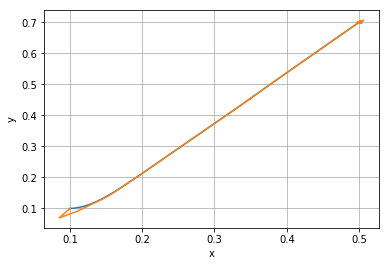

In [11]:
plt.plot(real_x[0,:],real_x[1,:],label='real trajectory')
plt.plot(sigma_points[0,0,:],sigma_points[1,0,:],label='estimated trajectory')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

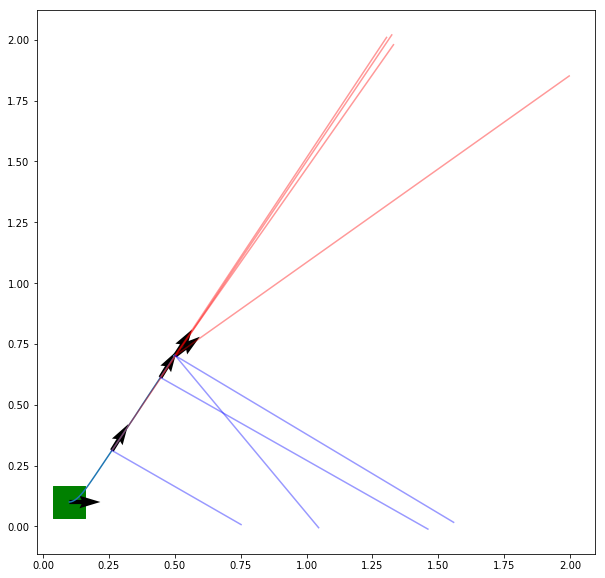

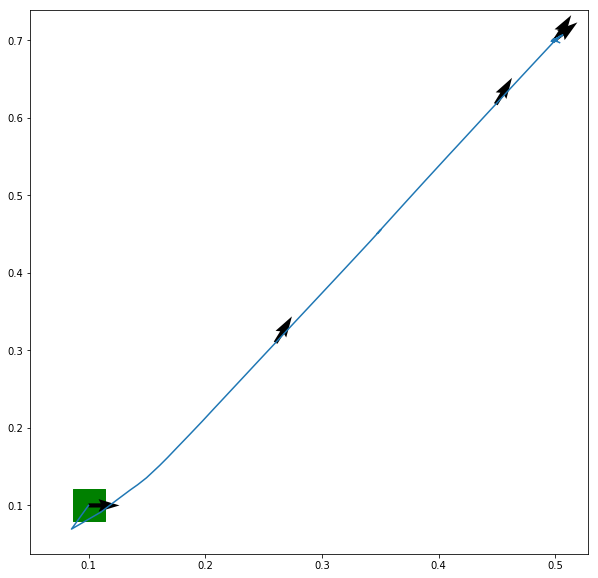

In [15]:
plot_trajectory(real_x,real_z)
plot_trajectory(sigma_points[:,0,:],np.zeros(sigma_points[:,0,:].shape))